## 1. Importacion de librerias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importar utilidades compartidas entre notebooks
from utils import (
    load_data,
    split_data_by_weeks,
    evaluate_model,
    save_metrics,
    plot_all_diagnostics,
    TARGETS,
    HORIZONS
)

# Configurar estilo de graficas
plt.style.use('seaborn-v0_8-notebook')

# Configuracion de directorios
OUTPUT_DIR = 'output/0_persistence'
MODEL_NAME = 'Persistencia (Naive)'


## 2. Carga de datos

In [ ]:
# Cargar dataset completo
df = load_data()


Datos cargados: 20,436,599 registros
Estaciones: 677
Periodo: 2025-05-02 00:00:00-06:00 a 2025-11-30 22:50:00-06:00
Features incluyen lags y trends precalculados: ocu_lag_1,2,6,12,138,144 y ocu_trend_1,2,6,12
Verificacion: No hay valores NaN en features ni targets


In [ ]:
# Dividir datos en train, validacion y test por semanas completas
train_df, val_df, test_df = split_data_by_weeks(df)


Total de semanas disponibles en el dataset: 31
Zona horaria utilizada: America/Mexico_City
Primera semana: 2025-W18
Ultima semana: 2025-W48

Semanas eliminadas del inicio: 1
  Primera semana eliminada: 2025-W18
  Ultima semana eliminada: 2025-W18

Semanas a utilizar: 30 (de 2025-W19 a 2025-W48)

Semanas asignadas:
  Train: 2025-W19 a 2025-W40 (22 semanas)
  Val:   2025-W41 a 2025-W44 (4 semanas)
  Test:  2025-W45 a 2025-W48 (4 semanas)

Division de datos:
  Entrenamiento: 14,854,057 registros (22 semanas)
  Validacion:    2,611,866 registros (4 semanas)
  Pruebas:       2,678,212 registros (4 semanas)

Rangos de fechas:
  Train: 2025-05-05 00:00:00-06:00 a 2025-10-05 23:50:00-06:00
  Val:   2025-10-06 00:00:00-06:00 a 2025-11-02 23:50:00-06:00
  Test:  2025-11-03 00:00:00-06:00 a 2025-11-30 22:50:00-06:00


## 3. Modelo de Persistencia

El modelo de persistencia para deltas de ocupacion es un baseline simple que predice cero cambio para todos los horizontes. Sirve como referencia minima de rendimiento para comparar con modelos mas sofisticados.

In [ ]:
class NaivePersistenceModel:
    """
    Modelo baseline que predice persistencia (sin cambio).
    
    Para prediccion de deltas de ocupacion, siempre predice 0,
    asumiendo que la ocupacion se mantendra constante.
    """
    
    def __init__(self):
        self.name = "Naive Persistence"
    
    def fit(self, X, y):
        """Metodo fit que no requiere entrenamiento."""
        pass
    
    def predict(self, X):
        """Predice un array de ceros del mismo tamaño que X."""
        return np.zeros(len(X))

# Crear instancia del modelo
model = NaivePersistenceModel()
print(f"Modelo: {model.name}")


Modelo: Naive Persistence


## 4. Evaluacion en conjunto de pruebas

In [ ]:
# Diccionarios para almacenar valores reales y predicciones por horizonte
y_true_dict = {}
y_pred_dict = {}

# Generar predicciones para cada horizonte temporal
for target in TARGETS:
    y_true_dict[target] = test_df[target].values
    y_pred_dict[target] = model.predict(test_df)

print(f"Registros en test: {len(test_df):,}")


Registros en test: 2,678,212


In [ ]:
# Obtener capacidades de las estaciones para calcular MAE en bicicletas
capacity = test_df['capacity'].values

# Primera evaluacion temporal para obtener MAE baseline
metrics_df_temp = evaluate_model(y_true_dict, y_pred_dict, capacity=capacity)

# Crear diccionario de MAE baseline (SS = 0 por definicion para este modelo)
baseline_mae_dict = {
    target: metrics_df_temp[metrics_df_temp['Horizonte'] == horizon]['MAE'].values[0]
    for target, horizon in zip(TARGETS, HORIZONS)
}

# Calcular metricas finales incluyendo Skill Score
metrics_df = evaluate_model(y_true_dict, y_pred_dict, capacity=capacity, baseline_mae_dict=baseline_mae_dict)

print("\nMetricas en conjunto de pruebas:")
print("=" * 70)
print(metrics_df.to_string(index=False))
print("=" * 70)
print("\nMAE_bikes: error promedio en numero de bicicletas")
print("SS (Skill Score): 0 para el modelo baseline por definicion")



Metricas en conjunto de pruebas:
 Horizonte      MAE     RMSE  MAE_bikes  SS
        20 0.041512 0.080741   1.077799 0.0
        40 0.062528 0.112425   1.628461 0.0
        60 0.078393 0.135338   2.046322 0.0

Nota: MAE_bikes es el error promedio en numero de bicicletas
      SS (Skill Score) = 0 para el modelo baseline


In [ ]:
# Guardar metricas en archivo CSV
save_metrics(metrics_df, OUTPUT_DIR)


Metricas guardadas en: output/0_persistence/metrics.csv


In [ ]:
import pickle

# Guardar diccionario de MAE baseline para uso en otros notebooks
baseline_file = f'{OUTPUT_DIR}/baseline_mae.pkl'
with open(baseline_file, 'wb') as f:
    pickle.dump(baseline_mae_dict, f)

print(f"Baseline MAE guardado en: {baseline_file}")
print("Este archivo se utiliza en otros notebooks para calcular Skill Score")


Baseline MAE guardado en: output/0_persistence/baseline_mae.pkl
Este archivo puede usarse en otros notebooks para calcular Skill Score


## 5. Visualizacion de resultados

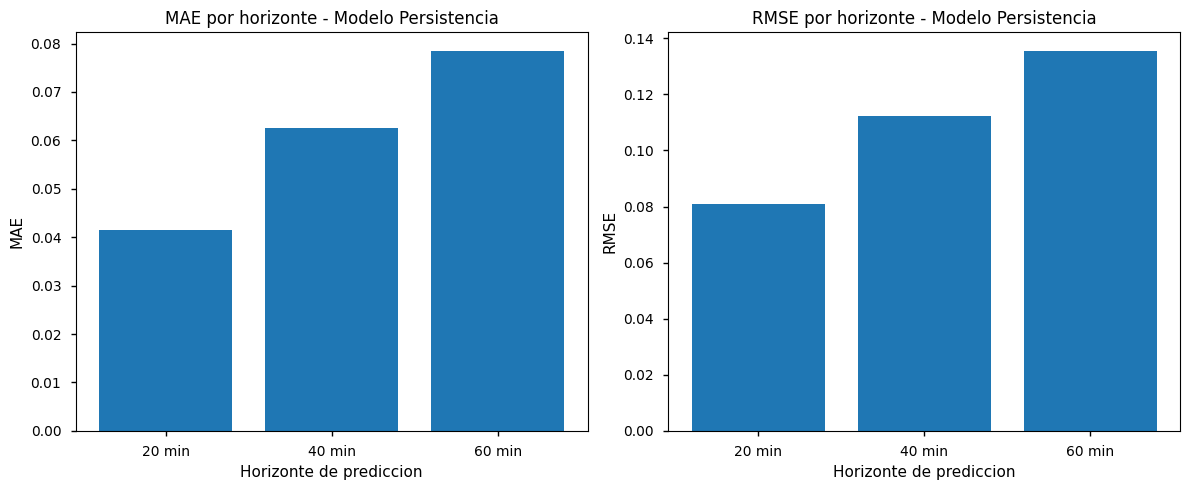

In [ ]:
# Crear figura con dos subplots para MAE y RMSE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Graficar MAE por horizonte
axes[0].bar(metrics_df['Horizonte'].astype(str) + ' min', metrics_df['MAE'])
axes[0].set_xlabel('Horizonte de prediccion')
axes[0].set_ylabel('MAE')
axes[0].set_title('MAE por horizonte - Modelo Persistencia')

# Graficar RMSE por horizonte
axes[1].bar(metrics_df['Horizonte'].astype(str) + ' min', metrics_df['RMSE'])
axes[1].set_xlabel('Horizonte de prediccion')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE por horizonte - Modelo Persistencia')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/metrics_by_horizon.png', dpi=300, bbox_inches='tight')
plt.show()


## 6. Graficas de diagnostico

In [ ]:
# Generar todas las graficas de diagnostico (scatter plots, residuales, etc.)
print("Generando graficas de diagnostico...")
plot_all_diagnostics(
    df_test=test_df,
    y_true_dict=y_true_dict,
    y_pred_dict=y_pred_dict,
    output_dir=OUTPUT_DIR,
    model_name=MODEL_NAME
)


Generando graficas de diagnostico...
  Estaciones seleccionadas:
    Alta actividad: 082
    Baja actividad: 244
    Actividad media: 392
  Generando graficas para horizonte 20 min...
  Generando graficas para horizonte 40 min...
  Generando graficas para horizonte 60 min...
Graficas guardadas en: output/0_persistence


## 7. Analisis de la distribucion de deltas reales

Analisis de las estadisticas descriptivas de los deltas reales para contextualizar el rendimiento del modelo baseline.

In [ ]:
# Mostrar estadisticas descriptivas de los deltas reales
print("Estadisticas de deltas reales en conjunto de pruebas:")
print("=" * 60)

for target, horizon in zip(TARGETS, HORIZONS):
    values = test_df[target].values
    print(f"\nHorizonte {horizon} min ({target}):")
    print(f"  Media:    {values.mean():.6f}")
    print(f"  Std:      {values.std():.6f}")
    print(f"  Min:      {values.min():.6f}")
    print(f"  Max:      {values.max():.6f}")
    print(f"  Mediana:  {np.median(values):.6f}")


Estadisticas de deltas reales en conjunto de pruebas:

Horizonte 20 min (ocu_delta_20):
  Media:    0.000059
  Std:      0.080741
  Min:      -1.000000
  Max:      1.000000
  Mediana:  0.000000

Horizonte 40 min (ocu_delta_40):
  Media:    0.000120
  Std:      0.112425
  Min:      -1.000000
  Max:      1.000000
  Mediana:  0.000000

Horizonte 60 min (ocu_delta_60):
  Media:    0.000182
  Std:      0.135337
  Min:      -1.000000
  Max:      1.000000
  Mediana:  0.000000


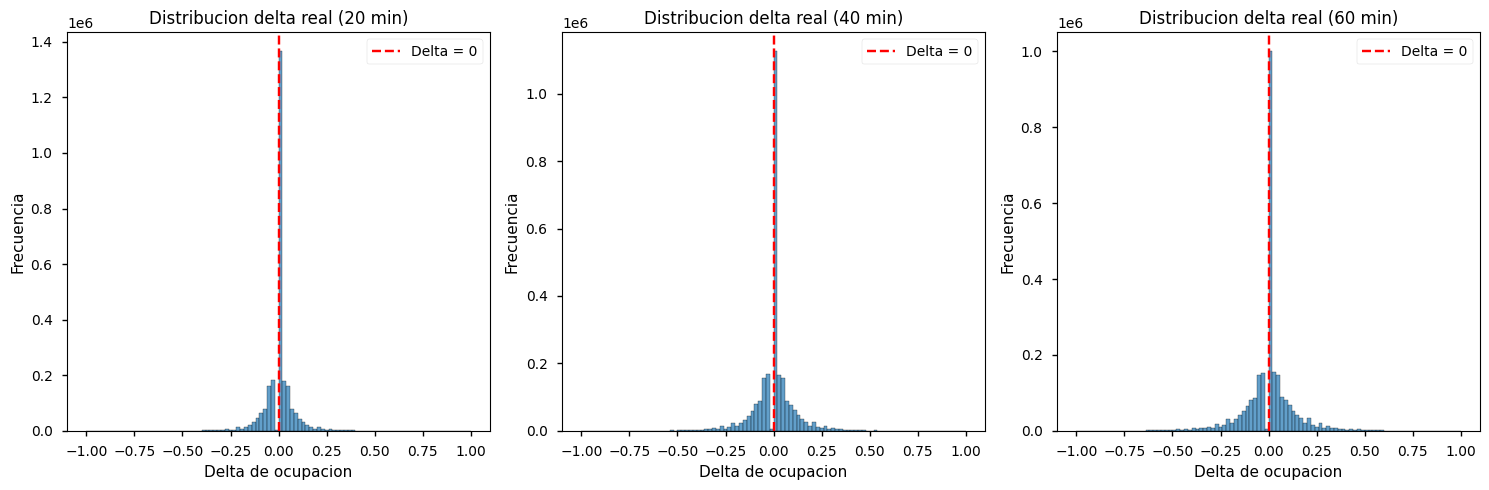

In [ ]:
# Crear histogramas de la distribucion de deltas reales
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (target, horizon) in enumerate(zip(TARGETS, HORIZONS)):
    axes[i].hist(test_df[target], bins=100, edgecolor='black', alpha=0.7)
    axes[i].axvline(x=0, color='red', linestyle='--', label='Delta = 0')
    axes[i].set_xlabel('Delta de ocupacion')
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_title(f'Distribucion delta real ({horizon} min)')
    axes[i].legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/real_delta_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


## 8. Resumen

El modelo de persistencia establece la linea base que todos los demas modelos deben superar.

In [13]:
print("=" * 70)
print("RESUMEN - MODELO NAIVE DE PERSISTENCIA")
print("=" * 70)
print(f"\nDescripcion: Predice delta = 0 (sin cambio)")
print(f"\nConjunto de pruebas: {len(test_df):,} registros")
print(f"\nMetricas:")
for _, row in metrics_df.iterrows():
    print(f"  Horizonte {int(row['Horizonte'])} min: MAE={row['MAE']:.6f}, RMSE={row['RMSE']:.6f}, MAE_bikes={row['MAE_bikes']:.2f}, SS={row['SS']:.4f}")
print(f"\nArchivos guardados en: {OUTPUT_DIR}")
print(f"  - metrics.csv: Metricas del modelo")
print(f"  - baseline_mae.pkl: MAE baseline para otros modelos")
print("=" * 70)


RESUMEN - MODELO NAIVE DE PERSISTENCIA

Descripcion: Predice delta = 0 (sin cambio)

Conjunto de pruebas: 2,678,212 registros

Metricas:
  Horizonte 20 min: MAE=0.041512, RMSE=0.080741, MAE_bikes=1.08, SS=0.0000
  Horizonte 40 min: MAE=0.062528, RMSE=0.112425, MAE_bikes=1.63, SS=0.0000
  Horizonte 60 min: MAE=0.078393, RMSE=0.135338, MAE_bikes=2.05, SS=0.0000

Archivos guardados en: output/0_persistence
  - metrics.csv: Metricas del modelo
  - baseline_mae.pkl: MAE baseline para otros modelos
